1. Import Libraries

In [14]:
# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset
from sklearn.datasets import load_breast_cancer

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Evaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

2. Load Dataset

In [15]:
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

print("Shape:", X.shape)
print(X.head())
print("Target classes:", data.target_names)

Shape: (569, 30)
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst radius  worst texture  worst perimete

3. Exploratory Data Analysis (EDA)

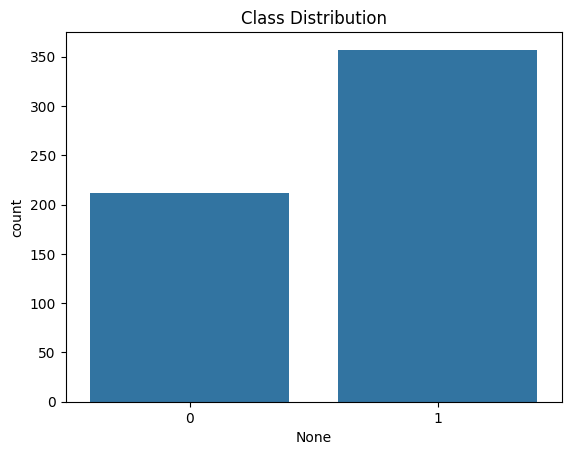

In [16]:
sns.countplot(x=y)
plt.title("Class Distribution")
plt.show()

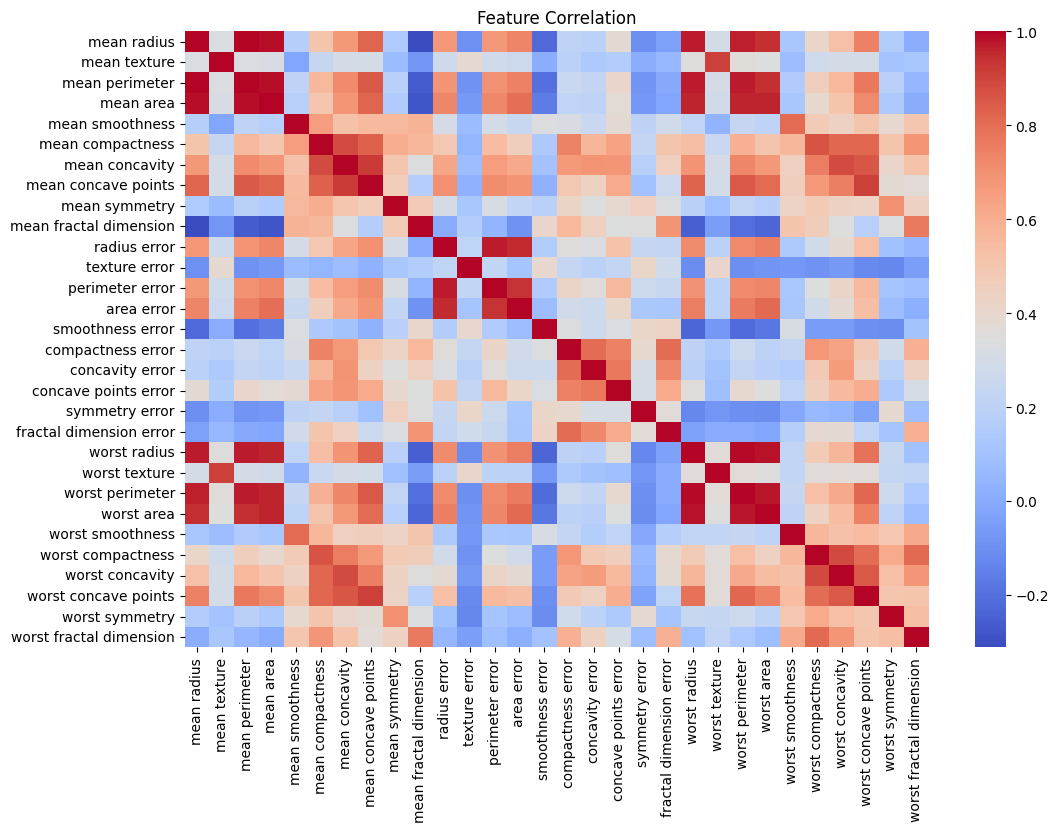

In [17]:
plt.figure(figsize=(12,8))
sns.heatmap(X.corr(), cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

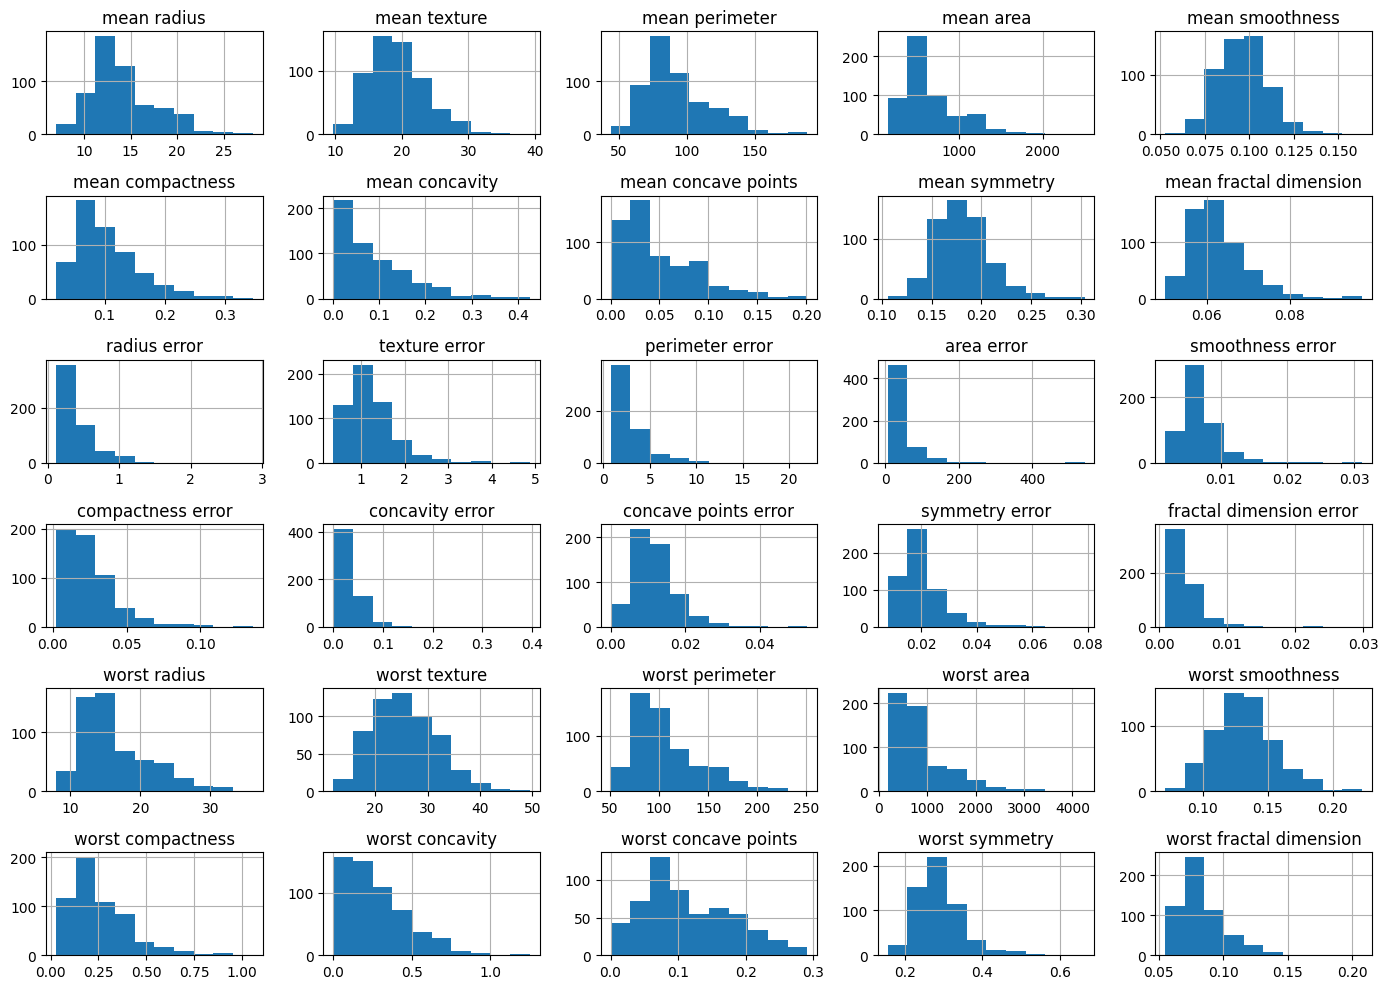

In [18]:
X.hist(figsize=(14,10))
plt.tight_layout()
plt.show()

4. Train Test Split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

5. Feature Selection

In [20]:
selector = SelectKBest(score_func=f_classif, k=10)

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

6. Machine Learning Pipelines

In [21]:
pipelines = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=5000))
    ]),

    "Random Forest": Pipeline([
        ("scaler", StandardScaler()),
        ("model", RandomForestClassifier())
    ]),

    "SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVC(probability=True))
    ])
}

7. Train Models

In [22]:
for name, pipe in pipelines.items():
    pipe.fit(X_train_selected, y_train)
    print(name, "trained")

Logistic Regression trained
Random Forest trained
SVM trained


8. Cross Validation

In [23]:
cv_results = {}

for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X_train_selected, y_train, cv=5)
    cv_results[name] = scores.mean()

print("Cross Validation Scores:")
print(cv_results)

Cross Validation Scores:
{'Logistic Regression': np.float64(0.9472527472527472), 'Random Forest': np.float64(0.9472527472527472), 'SVM': np.float64(0.9384615384615385)}


9. Hyperparameter Tuning (Random Forest)

In [24]:
param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20]
}

grid = GridSearchCV(
    pipelines["Random Forest"],
    param_grid,
    cv=5
)

grid.fit(X_train_selected, y_train)

best_rf = grid.best_estimator_
print("Best parameters:", grid.best_params_)

Best parameters: {'model__max_depth': None, 'model__n_estimators': 100}


10. Model Evaluation

In [25]:
models_to_evaluate = {
    "Logistic Regression": pipelines["Logistic Regression"],
    "Random Forest Tuned": best_rf,
    "SVM": pipelines["SVM"]
}

results = {}

for name, model in models_to_evaluate.items():
    preds = model.predict(X_test_selected)
    prob = model.predict_proba(X_test_selected)[:,1]

    results[name] = roc_auc_score(y_test, prob)

    print("Model:", name)
    print(classification_report(y_test, preds))
    print("ROC AUC:", results[name])
    print("------")

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.95      0.98      0.97        43
           1       0.99      0.97      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

ROC AUC: 0.9980347199475925
------
Model: Random Forest Tuned
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        43
           1       0.96      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

ROC AUC: 0.9949230265312806
------
Model: SVM
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96    

11. Model Comparison Table

In [26]:
comparison = pd.DataFrame(results.items(), columns=["Model", "ROC AUC"])
print(comparison)

                 Model   ROC AUC
0  Logistic Regression  0.998035
1  Random Forest Tuned  0.994923
2                  SVM  0.997707


12. Confusion Matrix + ROC + PR Curve

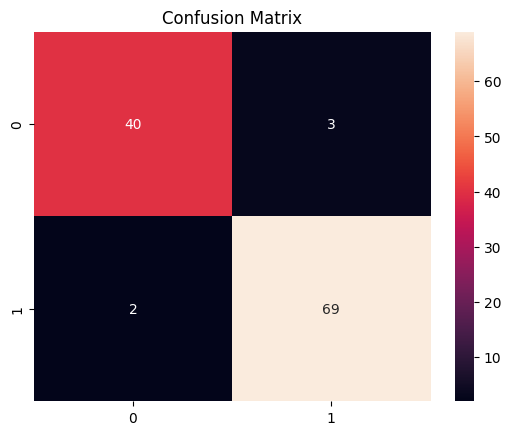

In [27]:
best_model = best_rf
preds = best_model.predict(X_test_selected)

cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()

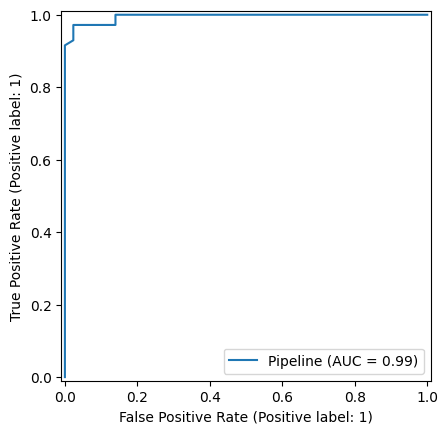

In [28]:
RocCurveDisplay.from_estimator(best_model, X_test_selected, y_test)
plt.show()

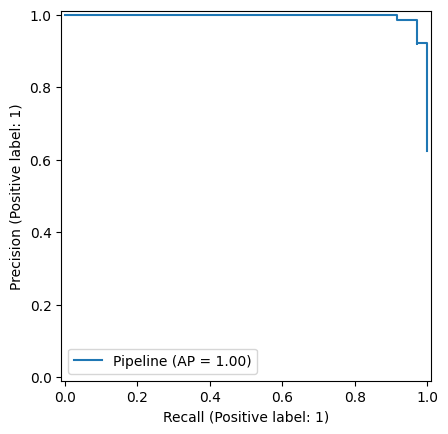

In [29]:
PrecisionRecallDisplay.from_estimator(best_model, X_test_selected, y_test)
plt.show()

13. Model Interpretation

                Feature  Importance
6       worst perimeter    0.211824
4   mean concave points    0.168173
9  worst concave points    0.167935
7            worst area    0.136227
5          worst radius    0.117294
2             mean area    0.057568
3        mean concavity    0.044351
8       worst concavity    0.043163
1        mean perimeter    0.028610
0           mean radius    0.024857


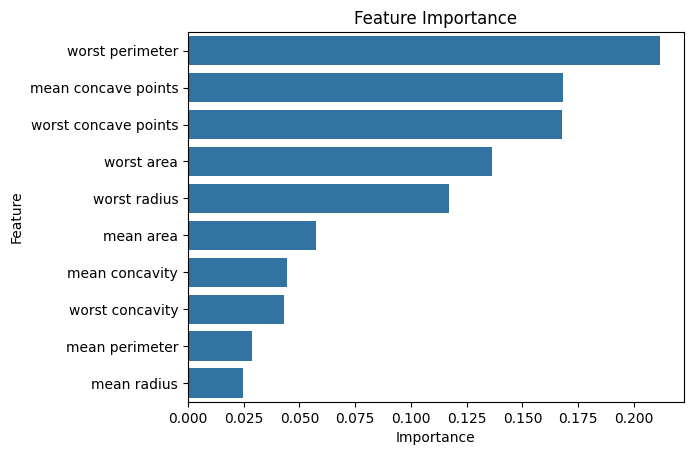

In [30]:
importances = best_rf.named_steps["model"].feature_importances_
selected_features = X.columns[selector.get_support()]

importance_df = pd.DataFrame({
    "Feature": selected_features,
    "Importance": importances
}).sort_values("Importance", ascending=False)

print(importance_df)

sns.barplot(data=importance_df, x="Importance", y="Feature")
plt.title("Feature Importance")
plt.show()